In [1]:
#purpose is to generate images in the steps below, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to given spitzer and hubble images
2) loop through all the data, read it in, convert units
3) cutout all the data as appropriate
3) create a loop or otherwise hardcode going through all the combinations of convolutions of images by hand...
4) regrid all the images
5) de-extinct all the images
6) create apertures as appropriate for all the knots
7) perform relevant analyses: e.g. taking ratio and then finding EDFs, summing up the intensities of each knot for noting and saving
'''

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys



3.8.13


C:\Users\arubi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(D, hdu_pix_torad, hdu_dat, lam, kern):
    #gaussian kernel
    if kern == 'gauss':
        #update: usually cannot find wavelength but these headers are well-labeled    
        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv

# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

This code uses cross correlation
Background paper examples
https://articles.adsabs.harvard.edu/pdf/1992ApJ...392..145R or https://iopscience.iop.org/article/10.1086/517493/pdf

Example stack overflow references...
https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images (the best)
https://stackoverflow.com/questions/61114057/how-to-estimate-motion-with-ftt-and-cross-correlation (not bad)
https://stackoverflow.com/questions/189943/how-can-i-quantify-difference-between-two-images (good conceptual explanation)

In [3]:
path = '../scaling_for_motions/160_epoch*.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
print(im_names_n2071)

im_names_n2071 = [im_names_n2071[0], im_names_n2071[2]]
print(im_names_n2071)

['../scaling_for_motions/160_epoch1.fits', '../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']
['../scaling_for_motions/160_epoch1.fits', '../scaling_for_motions/160_epoch2_synth.fits']


In [4]:
hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    
    #needed because the second image in this list is negative...
    if count == 1:
        sign = -1
    else:
        sign = 1
    hdu_data_list.append(sign * hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

In [5]:
#our plotting function
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')


In [6]:
%matplotlib inline

# Reading in a region file + indexing for cutouts
Seems like doing it with cutout2d for once worked better than doing it by hand...so let's just go with it.

Will help to then overlay this on the difference image

In [7]:
#trying this with cutout2d
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5, ICRS
from photutils.aperture import EllipticalAperture

#trying it by hand

#known pixel size
hst_pixsize = 0.12825 #arcsec

# f = open('moving_blobs.reg', 'r')
f1 = open('epoch1_361c_byhand_ellipses.reg', 'r')
f2 = open('epoch2_361c_byhand_ellipses.reg', 'r')
file1_output = []
file2_output = []

#looping through file 
for line in f1:
    file1_output.append(line)
f1.close()

for line in f2:
    file2_output.append(line)
f2.close()

#fix file contents
#contents are ra, dec, width, height, rotation
file1_output = [i[8:-2] for i in file1_output[3:-2]]
file2_output = [i[8:-2] for i in file2_output[3:-2]]


#next step is for image, loop through all regions and make a list of region properties
ra_pix_list = []
dec_pix_list = []
rad_a_list = []
rad_b_list = []
rotation_list = []

#coordinate details
split_params1 = [i.split(',') for i in file1_output]
split_params2 = [i.split(',') for i in file2_output]
ra_hms_list = [(ra1[0].split(':')[0]+'h' + ra1[0].split(':')[1]+'m' + ra1[0].split(':')[2]+'s', \
                ra2[0].split(':')[0]+'h' + ra2[0].split(':')[1]+'m' + ra2[0].split(':')[2]+'s') \
               for ra1, ra2 in zip(split_params1, split_params2)]
dec_dms_list = [(dec1[1].split(':')[0]+'d' + dec1[1].split(':')[1]+'m' + dec1[1].split(':')[2]+'s', \
                 dec2[1].split(':')[0]+'d' + dec2[1].split(':')[1]+'m' + dec2[1].split(':')[2]+'s') \
                for dec1, dec2 in zip(split_params1, split_params2)]
pos_list = [[SkyCoord(ra[0]+' '+dec[0], frame=FK5, unit=(u.hourangle, u.deg)), \
             SkyCoord(ra[1]+' '+dec[1], frame=FK5, unit=(u.hourangle, u.deg))] \
             for ra, dec in zip(ra_hms_list, dec_dms_list)]

#this isn't working for some reason...skycoord_to_pixel doesn't seem to like units? not sure
ra_pix_list = [[skycoord_to_pixel(i[0], wcs=WCS(hdu_header_list[0]))[0], \
               skycoord_to_pixel(i[1], wcs=WCS(hdu_header_list[1]))[0]] \
               for i in pos_list]
dec_pix_list = [[skycoord_to_pixel(i[0], wcs=WCS(hdu_header_list[0]))[1], \
               skycoord_to_pixel(i[1], wcs=WCS(hdu_header_list[1]))[1]] \
               for i in pos_list]

#aperture size details
rad_a_list = [[1./hst_pixsize * float(rad_a1[2][:-1]), 1./hst_pixsize * float(rad_a2[2][:-1])]
               for rad_a1, rad_a2 in zip(split_params1, split_params2)]
rad_b_list = [[1./hst_pixsize * float(rad_b1[2][:-1]), 1./hst_pixsize * float(rad_b2[2][:-1])]
               for rad_b1, rad_b2 in zip(split_params1, split_params2)]
rotation_list = [[float(rot1[4]), float(rot2[4])] for rot1, rot2 in zip(split_params1, split_params2)]

# Looping through regions

In [34]:
#see https://scikit-image.org/docs/stable/auto_examples/registration/plot_masked_register_translation.html

import numpy as np

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['Epoch 1 Knot Coordinates (dd:mm:ss, hh:mm:ss)', 'Epoch 2 Knot Coordinates (dd:mm:ss, hh:mm:ss)', \
                'RA Offset (arcsec)', 'Dec Offset (arcsec)', 'Position Angle (Degrees)', \
                'Proper Motion (arcsec/yr)', 'Tangential Speed (km/s)'] #columns
#creating dataframe and filling in the first two columns from the lists we just made
df_cc_speeds = pd.DataFrame(columns = column_names)
df_cc_speeds['Epoch 1 Knot Coordinates (dd:mm:ss, hh:mm:ss)'] = [str(i[0]) + ', ' + str(j[0]) for i, j in zip(ra_hms_list, dec_dms_list)]
df_cc_speeds['Epoch 2 Knot Coordinates (dd:mm:ss, hh:mm:ss)'] = [str(i[1]) + ', ' + str(j[1]) for i, j in zip(ra_hms_list, dec_dms_list)]
# df_cc_speeds['Knot Shift in X (pix)'] = [(i[0].ra.value-i[1].ra.value)*3600./hst_pixsize for i in pos_list]
# df_cc_speeds['Knot Shift in Y (pix)'] = [(i[0].dec.value-i[1].dec.value)*3600./hst_pixsize for i in pos_list]
df_cc_speeds['RA Offset (arcsec)'] = [(i[0] - i[1])*hst_pixsize for i in ra_pix_list]
df_cc_speeds['Dec Offset (arcsec)'] = [(i[0] - i[1])*hst_pixsize for i in dec_pix_list]
df_cc_speeds['Position Angle (Degrees)'] = theta_list

#computing table of speeds...
n2071_dist = 1.32715e16  #430.1 pc to km
pix_size = 0.12825
time = 3.469e8 #11 yrs to secs
horiz_propmot = [i /11. for i in df_cc_speeds['RA Offset (arcsec)'].values] #divided by 11 yrs
vert_propmot = [i /11. for i in df_cc_speeds['Dec Offset (arcsec)'].values] #divided by 11 yrs
horiz_speed = [i * n2071_dist/206265 / time for i in df_cc_speeds['RA Offset (arcsec)'].values] #convert pix->arcsec->use small angle formula for distance->div by t for speed
vert_speed = [i * n2071_dist/206265 / time for i in df_cc_speeds['Dec Offset (arcsec)'].values] #convert pix->arcsec->use small angle formula for distance->div by t for speed
#     print(horiz_speed, vert_speed)

df_cc_speeds['Proper Motion (arcsec/yr)'] =  [np.sqrt(i**2.+j**2.) for i,j in zip(horiz_propmot,vert_propmot)]
df_cc_speeds['Tangential Speed (km/s)'] = [np.sqrt(i**2.+j**2.) for i,j in zip(horiz_speed,vert_speed)]


#saving as excel file for use in future codes, make sure to update savepaths
# !conda install --yes --prefix {sys.prefix} openpyxl #may need...IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
# savepath = 'proper_motions.xlsx'
# df_cc_speeds = df_cc_speeds.sort_values(by=['Knot Dec (dd:mm:ss)'], ascending=True)
print(df_cc_speeds)
savepath = 'proper_motions_table.tex'
df_cc_speeds.to_latex(savepath, index=False)
print('saved speeds!')

  Epoch 1 Knot Coordinates (dd:mm:ss, hh:mm:ss)  \
0                  5h47m04.7278s, +0d21m54.424s   
1                  5h47m04.9050s, +0d22m15.608s   
2                  5h47m05.2484s, +0d22m27.308s   
3                  5h47m05.3264s, +0d22m28.448s   
4                  5h47m05.4630s, +0d22m30.251s   
5                  5h47m05.8456s, +0d22m37.350s   
6                  5h47m05.9158s, +0d22m39.970s   
7                  5h47m06.6270s, +0d22m44.653s   
8                  5h47m08.2013s, +0d22m53.882s   
9                  5h47m08.4797s, +0d22m54.173s   

  Epoch 2 Knot Coordinates (dd:mm:ss, hh:mm:ss)  RA Offset (arcsec)  \
0                  5h47m04.7749s, +0d21m56.281s           -1.465474   
1                  5h47m04.9316s, +0d22m17.079s           -1.017340   
2                  5h47m05.2577s, +0d22m28.261s           -0.552785   
3                  5h47m05.3562s, +0d22m29.181s           -0.728657   
4                  5h47m05.4940s, +0d22m30.948s           -0.728564   
5           

C:\Users\arubi\AppData\Local\Temp\ipykernel_7852\2199406584.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_cc_speeds.to_latex(savepath, index=False)


In [8]:
#functions to calculate angles between lines
#Credits: taken from https://stackoverflow.com/questions/25227100/best-way-to-plot-an-angle-between-two-lines-in-matplotlib

import math
from matplotlib.patches import Arc

def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1):

    l1xy = line1.get_xydata()
    l2xy = line2.get_xydata()

    # Angle between line1 and x-axis
    slope1 = -(l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle

    # Angle between line2 and x-axis
    slope2 = -(l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = str(angle)+u"\u00b0")

def get_angle_text(angle_plot):
    angle = angle_plot.get_label()[:-1] # Excluding the degree symbol
    angle = "%0.2f"%float(angle)+u"\u00b0" # Display angle upto 2 decimal places

    # Get the vertices of the angle arc
    vertices = angle_plot.get_verts()

    # Get the midpoint of the arc extremes
    x_width = (vertices[0][0] + vertices[-1][0]) / 2.0
    y_width = (vertices[0][-1] + vertices[-1][-1]) / 2.0

    #print x_width, y_width

    separation_radius = max(x_width/2.0, y_width/2.0)

    return [ x_width + separation_radius, y_width + separation_radius, angle]  



1
9


posx and posy should be finite values


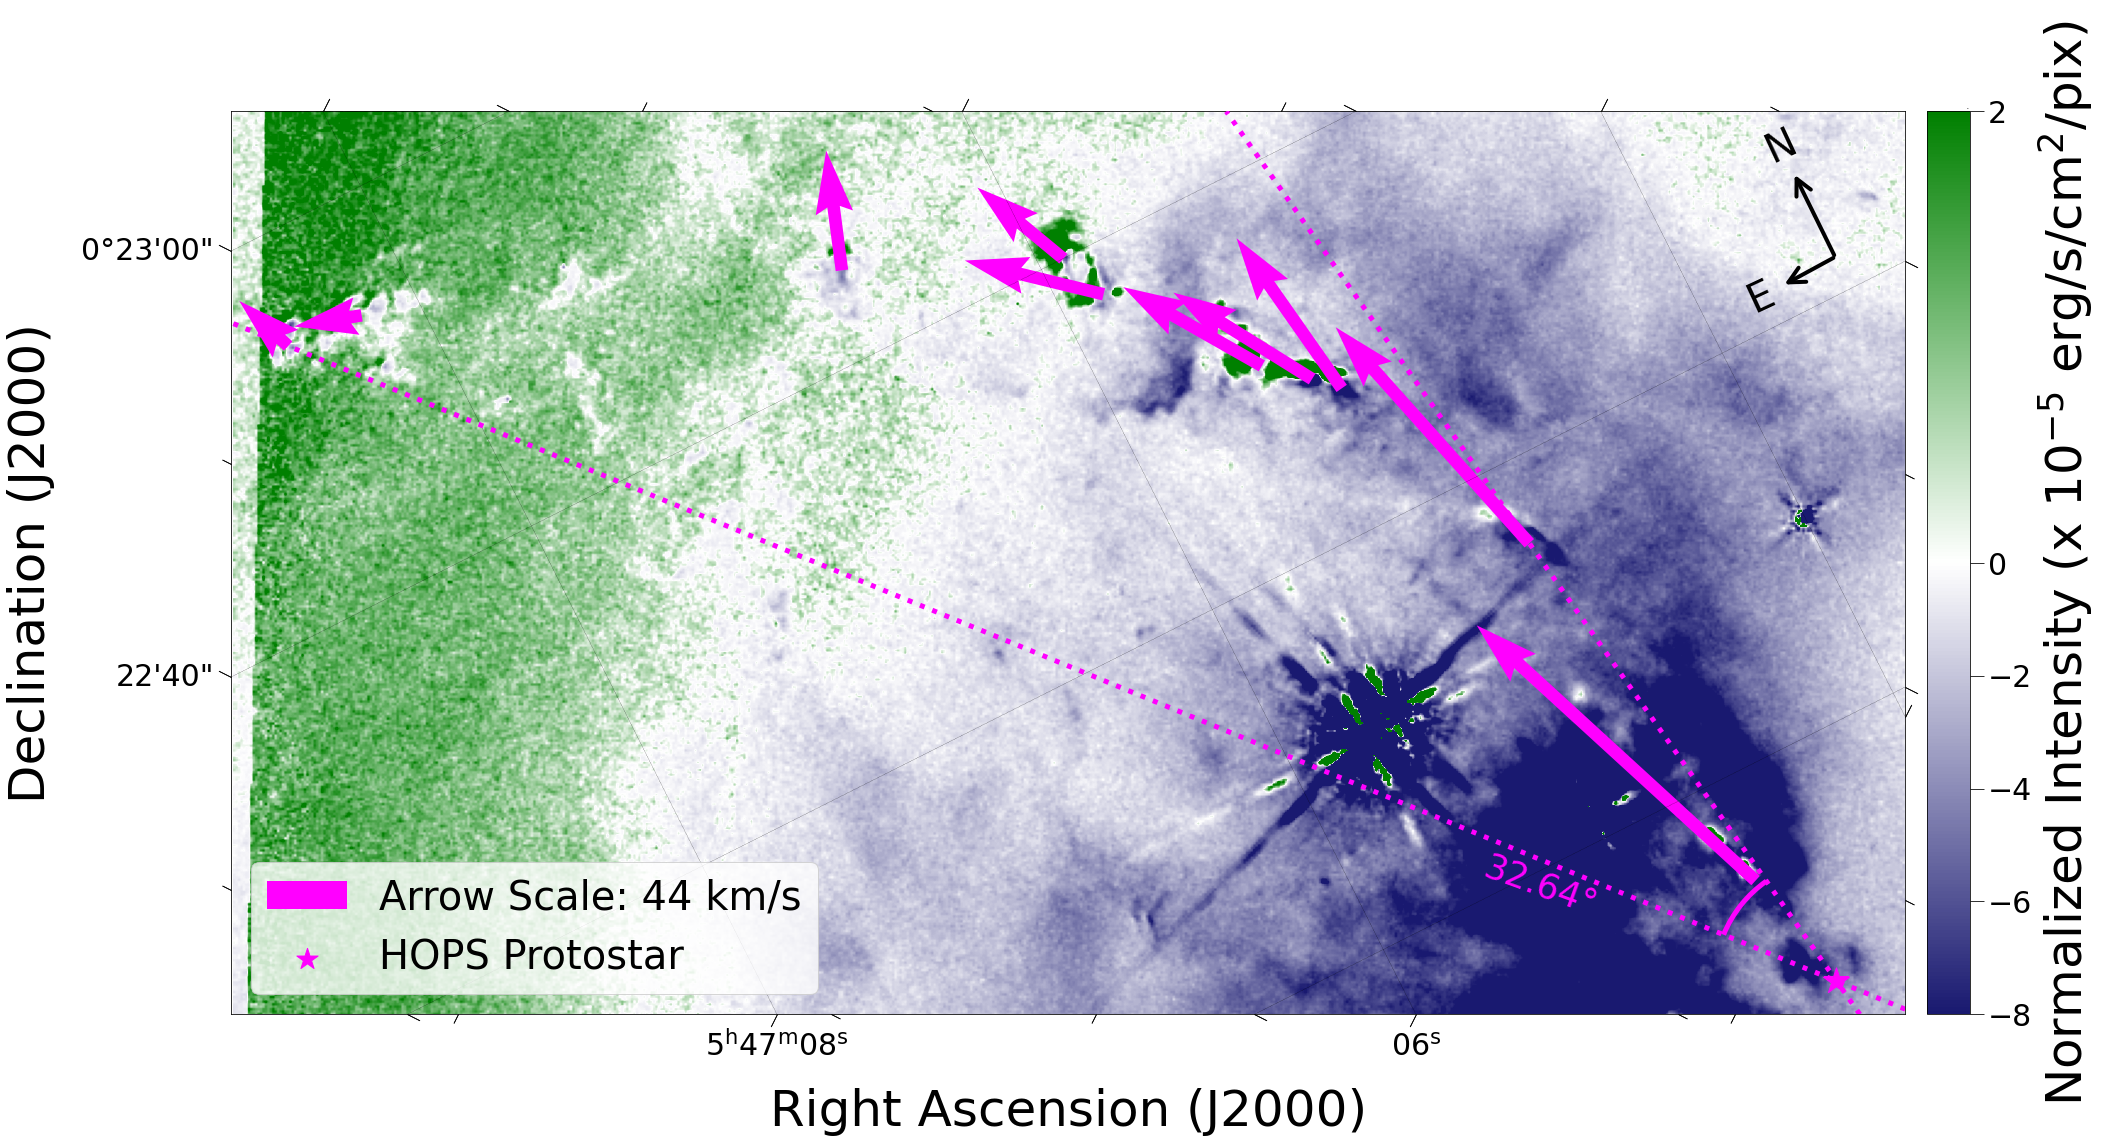

In [85]:
#overlaying on the difference image
diff_path = '../scaling_for_motions/f160_diff_epoch2_1.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
diff_hdu_list = fits.open(diff_path)
diff_data = diff_hdu_list[0].data
diff_header = diff_hdu_list[0].header

#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]
coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(diff_header)))
    
#begin plot
fig, ax = plt.subplots(figsize=(30, 20))
#projecting to correctly present data...
wcs = WCS(diff_header)
ax = plt.subplot(projection=wcs)


#plotting
interval = ZScaleInterval()
data_interval = interval.get_limits(diff_data)
ds9_min = -8e-05
ds9_max = 2e-05
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
norm = ImageNormalize(stretch=AsinhStretch(), vmin=ds9_min, vmax=ds9_max)

#plotting arrows and sources
import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["midnightblue","white","green"])
# im = ax.imshow(diff_data , norm=norm, origin='lower', cmap=cmap)#'seismic')
im = ax.imshow(diff_data , norm=TwoSlopeNorm(0, vmin=ds9_min, vmax=ds9_max), origin='lower', cmap=cmap)#'seismic')
hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='fuchsia', marker='*', s=750) for c_pair in coord_pix_list[2:3]]

#overplotting boxes and arrows to show how the method worked
from matplotlib import patches
from matplotlib.lines import Line2D
line_list = []
for ind in range(len(ra_pix_list)):
    #region params
    x_pix = ra_pix_list[ind]
    y_pix = dec_pix_list[ind]
#         theta_rad = rotation_list[ind] * np.pi/180.

    #arrow params
    x_origin = x_pix[0]#+width_pix/2. #-self_brightest_list[ind][1]
    y_origin = y_pix[0] #+height_pix/2. #-self_brightest_list[ind][0]
    dx = df_cc_speeds['Knot Shift in X (pix)'].values[ind]
    dy = df_cc_speeds['Knot Shift in Y (pix)'].values[ind]
    theta_calc = np.arctan(dy/dx)

    #plotting
    ax.quiver(x_origin, y_origin, np.sqrt(dx**2.+dy**2.)*np.cos(theta_calc), np.sqrt(dx**2.+dy**2.)*np.sin(theta_calc), \
             color='fuchsia', scale_units='xy', angles='xy', units='xy', scale=0.1)#, facecolor='hotpink', edgecolor='fuchsia')
    #violet, gray may be possible

    #labeling precession and relevant angles
    if ind == 1 or ind == len(ra_pix_list)-1:
        print(ind)
        line = Line2D([coord_pix_list[2][0], x_origin], [coord_pix_list[2][1], y_origin], color='fuchsia')
        m = (coord_pix_list[2][1] - y_origin) / (coord_pix_list[2][0] - x_origin)
        ax.axline(xy1=(coord_pix_list[2]), slope=m, color='fuchsia', linestyle=':', lw=5)
        line_list.append(line)

#legends, needs to be done before angles or else...
ax.quiver(0, 0, -2, 0, color='fuchsia', label='Arrow Scale: 44 km/s', scale_units='xy', angles='xy', units='xy', scale=0.1)
ax.scatter(0, 0, color='fuchsia', marker='*', s=500, label='HOPS Protostar')
ax.legend(loc='lower left', fontsize=40)

# Gets the arguments to be passed to ax.text as a list to display the angle value besides the arc
#adding angles, had to do calculation myself here because the function is confusing
#...one day should just use get_angle_plot() function, but it isn't working now
from matplotlib.patches import Arc
l1xy = line_list[0].get_xydata()
l2xy = line_list[1].get_xydata()

# Angle between line1 and x-axis
slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
angle1 = (math.degrees(math.atan(slope1))) # Taking only the positive angle
# Angle between line2 and x-axis
slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
angle2 = (math.degrees(math.atan(slope2)))

theta1 = min(angle1, angle2)
theta2 = max(angle1, angle2)

offset=2
ax.add_patch(Arc((coord_pix_list[2][0], coord_pix_list[2][1]), 100, 100, angle=0, theta1=theta1, theta2=theta2, \
             color='fuchsia', lw=5))
angle_plot = get_angle_plot(line_list[0], line_list[1], offset=1, color='fuchsia', origin=(410, 420)) #increasing x pushes it left, increasing y pushes it down
angle_text = get_angle_text(angle_plot) 
ax.add_patch(angle_plot) # To display the angle arc
ax.text(*angle_text, fontsize=35, color='fuchsia', rotation=-20) # To display the angle value


#adding a compass
theta_wcs = (135+180)*np.pi/180
x, y, arrow_length = 0.873, 0.775, 0.1
compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*np.sin(theta_wcs+np.pi/3.), y+arrow_length*np.cos(theta_wcs+np.pi/3.)), 
            arrowprops=dict(arrowstyle='<-', lw=4, facecolor='black'),
            ha='center', va='center', fontsize=40, rotation=25,
            xycoords='subfigure fraction') #ax.transAxes)
compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length/2*np.cos(theta_wcs+np.pi/2.), y-arrow_length/2*np.sin(theta_wcs+np.pi/2.)), 
            arrowprops=dict(arrowstyle='<-', lw=4, facecolor='black'),
            ha='center', va='center', fontsize=40, rotation=25,
            xycoords='subfigure fraction') #ax.transAxes)

#angular scale bar
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# AnchoredSizeBar(ax.transData, 100, '5 pixels = ' + str(5/hst_pixsize) + ' arcsecs = ' + str(5/hst_pixsize * 430.1/206265), \
#                (86.7699375, 0.36190278), label_top=True, color='fuchsia')
# ax.plot([500,500+1/hst_pixsize * 5], [550, 550], color='black', label='Angular Scale:10 pixels = ~1.3 arcsec')

#general formatting
ax.set_xlim(445, diff_data.shape[1]) #zoom in
ax.set_ylim(300, 670)
ax.coords.grid(True, color='black', ls='--', linewidth=0.25) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=50) #labels
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=50)   
ax.coords[0].set_minor_frequency(2) #for minor ticks
ax.coords[1].set_minor_frequency(2)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
ax.invert_yaxis() #done because it's nicer with declination increasing going up
ax.invert_xaxis()

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=30)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Normalized~Intensity~(x~{10}^{-5}~erg/s/{cm}^{2}/pix)$', size=50)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]

plt.savefig('f160w_diff_epoch21_arrowsbyhand.png', dpi=300, bbox_inches="tight")
plt.savefig('f160w_diff_epoch21_arrowsbyhand.pdf', dpi=300, bbox_inches="tight")

In [25]:
# x-arrow_length*np.sin(theta_wcs+np.pi/3.), y+arrow_length*np.cos(theta_wcs+np.pi/3.)
# x-arrow_length/2*np.cos(theta_wcs+np.pi/2.), y-arrow_length/2*np.sin(theta_wcs+np.pi/2.)
135+180+60, 135+180+90 #quadrants are second quadrant, third quadrant

#let's say it's 15 deg from up on the image, left on the image...then...
#thus the actual angles of interest are 90+15=105 and 15+180=195

(375, 405)

# Finding Avg Shock Speed for Apertures

In [25]:
# #retrieving data
path = '../watson_shock_ratio_contours/*.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_shock = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
im_names_shock = [i.replace('\\', '/') for i in im_names_shock]
print(im_names_shock)

hdu_list = [fits.open(i) for i in im_names_shock]

#initializing some lists to be used
shock_data_list = []
shock_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    shock_data_list.append(hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    shock_header_list.append(hdu_data[0].header)
    
    count+=1

#setting up to ignore 0 values
shock_data_list[0][shock_data_list[0] == 0] = np.nan

['../watson_shock_ratio_contours/mappings_shock_speed.fits']


In [26]:
#applying this to the second epoch...

# #making apertures
aperture_list = []
aper_mask_list = []
for i in range(len(ra_pix_list)):
    aperture_list.append(EllipticalAperture([ra_pix_list[i][1], dec_pix_list[i][1]], 
                                       rad_a_list[i][1], rad_b_list[i][1], theta=rotation_list[i][1]))
    aper_mask_list.append(aperture_list[i].to_mask())

#cutting out data
aper_cutout_list = [i.cutout(shock_data_list[0]) for i in aper_mask_list]
shock_avgspeed_list = [np.nanmean(i) for i in aper_cutout_list]

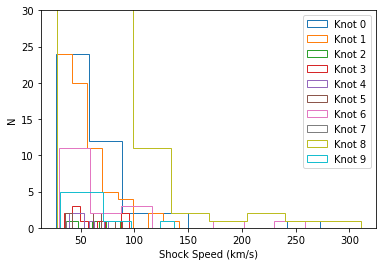

In [27]:
#histograms to check out the shock speeds
for i in range(len(aper_cutout_list)):
#     if i != 8:
    shock_speed_flat = aper_cutout_list[i].flatten()
    plt.hist(shock_speed_flat, label='Knot '+str(i), bins=8, histtype='step')
# plt.xlim(20, 100)
plt.xlabel('Shock Speed (km/s)')
plt.ylim(0, 30)
plt.ylabel('N')
plt.legend(loc='best')

# Trying some trends

In [9]:
#the coordinates of HOPS 361C
hops_361c_coord = SkyCoord('5h47m4.631s', '0d21m47.82s', frame=FK5)

hops_361a_coord = SkyCoord('5h47m4.784s', '0d21m42.85s', frame=FK5)
hops_361b_coord = SkyCoord('5h47m4.755s', '0d21m45.45s', frame=FK5)
hops_361d_coord = SkyCoord('5h47m4.317s', '0d21m38.03s', frame=FK5)
hops_361e_coord = SkyCoord('5h47m4.623s', ' 0d21m41.30s', frame=FK5)


knot_source_sep = [hops_361c_coord.separation(i[1]).arcsecond for i in pos_list] #arcsec
knot_source_sep_notc = [hops_361e_coord.separation(i[1]).arcsecond for i in pos_list] #trying out other stars...
knot_source_dist = np.array([i* 430.1/206265 for i in knot_source_sep]) #hardcoded the dist to 2071 in pc

In [10]:
knot_source_dist

array([0.01820776, 0.06173051, 0.08657498, 0.08917799, 0.09389317,
       0.11140937, 0.11715022, 0.13485113, 0.17794939, 0.18407689])

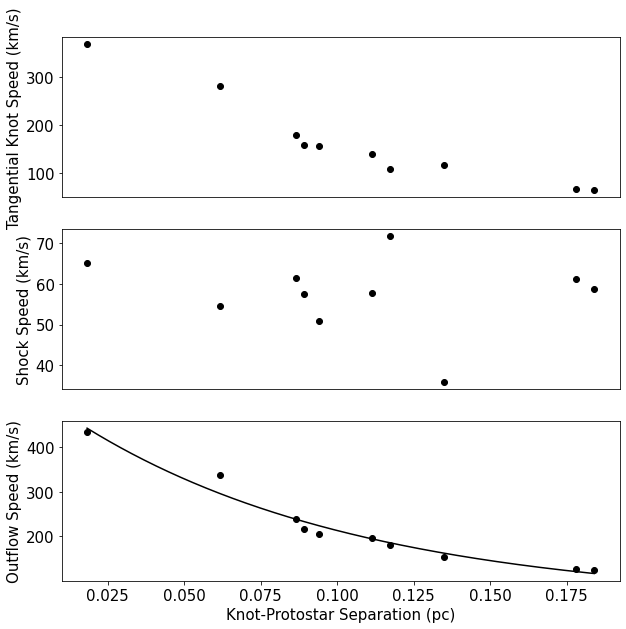

In [28]:
fig, ax = plt.subplots(3,1, figsize=(10, 10))

#fit is maybe linear, quadratic, hyperbolic, power law?
ax[0].scatter(knot_source_dist, df_cc_speeds['Tangential Speed (km/s)'].values, color='black')
ax[0].set_ylabel('Tangential Knot Speed (km/s)', fontsize=15)
ax[0].get_xaxis().set_visible(False)
ax[0].tick_params(axis='y', labelsize=15)

#fit is maybe linear, quadratic, hyperbolic, power law?
ax[1].scatter(knot_source_dist, shock_avgspeed_list, color='black')
ax[1].set_ylabel('Shock Speed (km/s)', fontsize=15)
ax[1].get_xaxis().set_visible(False)
ax[1].tick_params(axis='y', labelsize=15)

#plotting outflow speed...
outflow_speeds = shock_avgspeed_list+df_cc_speeds['Tangential Speed (km/s)'].values
ax[2].scatter(knot_source_dist, outflow_speeds, color='black')

#fit is exponential decay then because drag?
#https://ufla.br/dcom/wp-content/uploads/2017/01/artigo-publicado-na-revista-Physics-Education.pdf
from scipy.optimize.minpack import curve_fit
guess_a, guess_b, guess_c = 1, 1, 1
guess = [guess_a, guess_b, guess_c]
exp_decay = lambda x, A, t, y0: A * np.exp(x * t) + y0
params, cov = curve_fit(exp_decay, knot_source_dist, outflow_speeds, p0=guess)
A, t, y0 = params

#plotting best fit decay
best_fit = lambda x: A * np.exp(t * x) + y0
dist_interp = np.linspace(np.min(knot_source_dist), np.max(knot_source_dist), 500)
ax[2].plot(dist_interp, best_fit(dist_interp), 'k-')

#formatting
ax[2].set_ylabel('Outflow Speed (km/s)', fontsize=15)
ax[2].set_xlabel('Knot-Protostar Separation (pc)', fontsize=15)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)

plt.savefig('speed_dist_trends.png', dpi=300, bbox_inches="tight")

(0.0, 450.0)

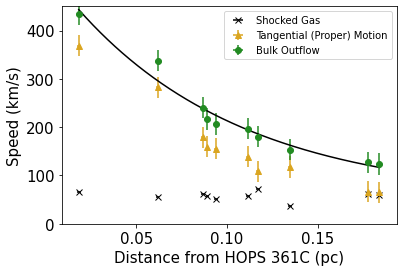

In [29]:
#errorbars are from 2 pixels...need to try to reduce it down to 1 pixel or sub-pixel
#1 pixel is about 22 km/s and about 0.001 pc
plt.errorbar(knot_source_dist, shock_avgspeed_list, xerr=0.001, color='black', marker='x', label='Shocked Gas', linestyle='')
plt.errorbar(knot_source_dist, df_cc_speeds['Tangential Speed (km/s)'].values, xerr=0.001, yerr=22, color='goldenrod', marker='^', label='Tangential (Proper) Motion', linestyle='')
plt.errorbar(knot_source_dist, outflow_speeds, yerr=22, xerr=0.001, color='forestgreen', marker='o', label='Bulk Outflow', linestyle='')

#plotting best fit decay (testing linear here, but it turns out worse)
# guess_a, guess_b = 1, 1
# guess_linear = [guess_a, guess_b]
# linear = lambda x, m, b: m*x + b
# params, cov = curve_fit(linear, knot_source_dist, outflow_speeds, p0=guess_linear)
# m, b = params
# best_fit = lambda x: m*x + b
dist_interp = np.linspace(np.min(knot_source_dist), np.max(knot_source_dist), 500)
plt.plot(dist_interp, best_fit(dist_interp), 'k-')

#formatting
plt.legend(loc='best')
plt.ylabel('Speed (km/s)', fontsize=15)
plt.xlabel('Distance from HOPS 361C (pc)', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.ylim(0, 450)

In [33]:
# shock_avgspeed_list

df_cc_speeds['Tangential Speed (km/s)'].values

array([342.45220724, 262.70171128, 166.00890489, 147.97729993,
       144.41463466, 129.30334903, 101.06595729, 109.31872491,
        61.71209086,  60.2167025 ])

# account for angle

**next = Take dot product between displacement vector and velocity vector so that we have one reference point for 
the ballistically expected motion and one reference point for the the actual knot motion**

In [22]:
theta_list = []
for ind in range(len(ra_pix_list)):
    #finding angle
    dx = df_cc_speeds['RA Offset (arcsec)'].values[ind]
    dy = df_cc_speeds['Dec Offset (arcsec)'].values[ind]
    theta_calc = np.arctan(dy/dx) * 180/np.pi
    theta_list.append(theta_calc)

theta_list = np.array(theta_list) +90- 26.71875 #the amount to rotate the frame from horizontal when originally to celestial north
# +90-15 #we add 90 because currently this is rel to left on page, -15 bc of where north on the sky is
print(theta_list)

knot_source_pa = np.array([hops_361c_coord.position_angle(i[1]).degree for i in pos_list])
print(knot_source_pa)

[ 20.80749266  15.15412695   8.30606018  31.35366927  33.68689179
  49.60017256  23.65768808 -19.21320746  72.75761084  20.59155455]
[14.31128073  8.76054827 13.08573056 14.73487355 16.70694884 20.59027569
 20.3167963  27.36926166 39.16356146 40.94520315]


4.071757922581721


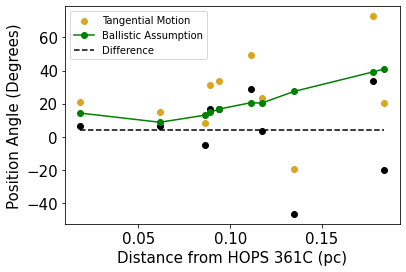

In [23]:
#actual proper motion angles
plt.scatter(knot_source_dist, theta_list, color='goldenrod', label='Tangential Motion')
# plt.scatter(knot_source_dist[0:2], theta_list[0:2], color='goldenrod', label='Tangential Motion')
# plt.scatter(np.mean(knot_source_dist[3:5]), np.mean(theta_list[3:5]), color='goldenrod')
# plt.scatter(np.mean(knot_source_dist[5:7]), np.mean(theta_list[5:7]), color='goldenrod')
# plt.scatter(knot_source_dist[7], theta_list[7], color='goldenrod')
# plt.scatter(np.mean(knot_source_dist[8:11]), np.mean(theta_list[8:11]), color='goldenrod')

#angle from protostar to knot, if ballistic
plt.plot(knot_source_dist, knot_source_pa, color = 'green', marker='o', label='Ballistic Assumption')

#trying to figure out the difference...likely due to inclination?
plt.scatter(knot_source_dist, theta_list-knot_source_pa, color='black')
# plt.scatter(knot_source_dist[0:2], theta_list[0:2]-knot_source_pa[0:2], color='black')
# plt.scatter(np.mean(knot_source_dist[3:5]), np.mean(theta_list[3:5]-knot_source_pa[3:5]), color='black')
# plt.scatter(np.mean(knot_source_dist[5:7]), np.mean(theta_list[5:7]-knot_source_pa[5:7]), color='black')
# plt.scatter(knot_source_dist[7], theta_list[7], color='black')
# plt.scatter(np.mean(knot_source_dist[8:11]), np.mean(theta_list[8:11]-knot_source_pa[8:11]), color='black')
plt.plot(knot_source_dist, [np.mean(theta_list-knot_source_pa)] * len(knot_source_dist), color='black', linestyle='--', label='Difference')
print(np.mean(theta_list-knot_source_pa))

#formatting
plt.legend(loc='best')
plt.ylabel('Position Angle (Degrees)', fontsize=15)
plt.xlabel('Distance from HOPS 361C (pc)', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

In [32]:
theta_uncert_list = []
for ind in range(len(ra_pix_list)):
    #finding angle
    dx = df_cc_speeds['RA Offset (arcsec)'].values[ind]
    dy = df_cc_speeds['Dec Offset (arcsec)'].values[ind]
    theta_offset_calc = np.arctan((dy+1)/(dx)) * 180/np.pi + 90- 26.71875 #calculating with an offset of 1 pixel
    theta_uncert_list.append(theta_offset_calc - theta_list[ind])
print(theta_uncert_list)

[-15.486418697907396, -16.39401248258479, -17.851707049376827, -31.45572280579428, -33.142331048012, -44.55863220623822, -32.17951474377152, -4.593799101029958, -78.90629274165968, -35.58135016803026]


In [54]:
#calculating a confidence interval
#based on https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit

# y_means = np.array(outflow_speeds).mean(axis = 1) # averages and dispersion of data
y_spread = [22]*len(outflow_speeds) #np.array(outflow_speeds).std(axis = 1)

from scipy.optimize.minpack import curve_fit
guess_a, guess_b, guess_c = 1, 1, 1
guess = [guess_a, guess_b, guess_c]
exp_decay = lambda x, A, t, y0: A * np.exp(x * t) + y0
params, cov = curve_fit(exp_decay, knot_source_dist, outflow_speeds, p0=guess, sigma=y_spread, absolute_sigma=True)
sigma_p = np.sqrt(np.diagonal(cov))
print(sigma_p)
A, t, y0 = params

#plotting best fit decay
best_fit = lambda x: A * np.exp(t * x) + y0
dist_interp = np.linspace(np.min(knot_source_dist), np.max(knot_source_dist), 500)

[42.9150313   3.08044436 52.09951114]


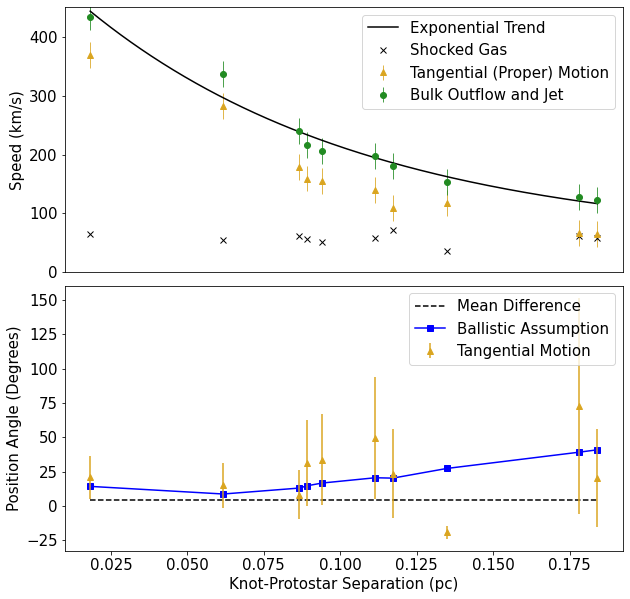

In [33]:
fig, ax = plt.subplots(2,1, figsize=(10, 10))

#plotting speed data
ax[0].errorbar(knot_source_dist, shock_avgspeed_list, color='black', marker='x', label='Shocked Gas', linestyle='', linewidth=0.8)
ax[0].errorbar(knot_source_dist, df_cc_speeds['Tangential Speed (km/s)'].values, yerr=22, color='goldenrod', marker='^', label='Tangential (Proper) Motion', linestyle='', linewidth=0.8)
ax[0].errorbar(knot_source_dist, outflow_speeds, yerr=22, color='forestgreen', marker='o', label='Bulk Outflow and Jet', linestyle='', linewidth=0.8)

# plotting the confidence intervals and fit
ax[0].plot(dist_interp, best_fit(dist_interp), 'k-', label='Exponential Trend') #fit
# bound_upper = exp_decay(dist_interp, *(params + sigma_p))
# bound_lower = exp_decay(dist_interp, *(params - sigma_p))
# ax[0].fill_between(dist_interp, bound_lower, bound_upper, color = 'black', alpha = 0.15)

ax[0].set_ylim(0, 450) #formatting
ax[0].set_ylabel('Speed (km/s)', fontsize=15)
ax[0].get_xaxis().set_visible(False)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].legend(loc='best', fontsize=15)

#plotting angular, unsure on fit
# ax[1].scatter(knot_source_dist, theta_list, color='goldenrod')
# ax[1].errorbar(knot_source_dist[0:2], theta_list[0:2], color='goldenrod', yerr=theta_uncert_list[0:2], linestyle='', linewidth=0.8, marker='o')
# ax[1].errorbar(np.mean(knot_source_dist[3:5]), np.mean(theta_list[3:5]), color='goldenrod', yerr=np.mean(theta_uncert_list[3:5]), linestyle='', linewidth=0.8, marker='o')
# ax[1].errorbar(np.mean(knot_source_dist[5:7]), np.mean(theta_list[5:7]), color='goldenrod', yerr=np.mean(theta_uncert_list[5:7]), linestyle='', linewidth=0.8, marker='o')
# ax[1].errorbar(knot_source_dist[7], np.mean(theta_list[7]), color='goldenrod', yerr=theta_uncert_list[7], linestyle='', linewidth=0.8, marker='o')
# ax[1].errorbar(np.mean(knot_source_dist[8:11]), np.mean(theta_list[8:11]), color='goldenrod', yerr=np.mean(theta_uncert_list[8:11]), linestyle='', linewidth=0.8, marker='o')

# ax[1].scatter(knot_source_dist, theta_list-knot_source_pa, color='black')
ax[1].plot(knot_source_dist, [np.mean(theta_list-knot_source_pa)] * len(knot_source_dist), color='black', linestyle='--', label='Mean Difference')
ax[1].plot(knot_source_dist, knot_source_pa, color = 'blue', marker='s', label='Ballistic Assumption')
ax[1].errorbar(knot_source_dist, theta_list, yerr=np.abs(theta_uncert_list), color='goldenrod', label='Tangential Motion', linestyle='', marker='^')

ax[1].set_ylabel('Position Angle (Degrees)', fontsize=15)
ax[1].tick_params(axis='y', labelsize=15)

#formatting x-axis
ax[1].set_xlabel('Knot-Protostar Separation (pc)', fontsize=15)
ax[1].tick_params(axis='x', labelsize=15)
plt.subplots_adjust(hspace=0.05)
ax[1].legend(loc='best', fontsize=15)

plt.savefig('speed_dist_trends.png', dpi=300, bbox_inches="tight")
plt.savefig('speed_dist_trends.pdf', dpi=300, bbox_inches="tight")